In [141]:
# %load ../qbiome/data_formatter.py
import pandas as pd

class DataFormatter():
    def __init__(self):
        pass

    def load_data(self, fpath_data, fpath_meta, taxon_name='Phylum',
    time_column_name='Age (days)', time_column_name_out='day',
    k_years=2, k_biomes=15):
        """
        fpath_data:
        fpath_meta:
        taxon: name of the taxon column, must have proper capitalization
        time_column_name: name of the timestamp column in the meta file
        time_column_name_out: name of the timestamp column in the data frame produced
        k_years:
        k_biomes:
        """
        taxa_raw = pd.read_csv(fpath_data)
        meta_raw = pd.read_csv(fpath_meta)
        taxa_sum = self._sum_taxon(taxa_raw, taxon_name)
        meta = self._parse_meta(meta_raw, time_column_name, time_column_name_out)
        data = self._join_data_meta(taxa_sum, meta, time_column_name_out)

        # depending on the unit of the timestamp in the original data,
        # it may be necessary to cut out days beyond 2 or more years
        # and to convert days to weeks
        data = self._cut_after_k_years(data, k_years)
        data = self._convert_days_to_weeks(data)

        data = self._use_top_k_biomes(data, k_biomes)
        return data

    def pivot_into_qnet_format(self, data):
        # keep sample_id in here for later cohort identification
        pivoted = data.pivot_table(index=['sample_id', 'week'],
        columns=['variable'])['value'].reset_index()
        pivoted.sort_values(by=['week'], inplace=True)
        pivoted.reset_index(drop=True, inplace=True)
        return pivoted

    def melt_into_plot_format(self, data):
        melted = data.melt(id_vars=['sample_id', 'week'])
        return melted

    def _sum_taxon(self, taxa_raw, taxon_name):
        taxa = taxa_raw[['Sample ID', taxon_name, 'Relative Abundance']]
        taxa_sum = taxa.groupby(by=['Sample ID', taxon_name]).sum()
        taxa_sum.reset_index(inplace=True)
        taxa_sum.columns = ['sample_id', 'variable', 'value']
        print('There are {} unique biomes and {} unique samples'.format(
            len(taxa_sum.variable.unique()), len(taxa_sum.sample_id.unique())))
        return taxa_sum

    def _parse_meta(self, meta_raw, time_column_name, time_column_name_out):
        meta = meta_raw[['Sample ID', 'Property', 'Value']]

        meta_timestamp = meta[meta['Property'] == time_column_name].drop(columns='Property')
        meta_timestamp.columns = ['sample_id', time_column_name_out]

        meta_subject_id = meta[meta['Property'] == 'Subject ID'].drop(columns='Property')
        meta_subject_id.columns = ['sample_id', 'subject_id']

        meta = pd.merge(meta_timestamp, meta_subject_id, on='sample_id')
        return meta

    def _join_data_meta(self, data, meta, time_column_name):
        merged = pd.merge(data, meta, how='outer', on='sample_id')
        merged.columns = ['sample_id', 'variable', 'value', time_column_name, 'subject_id']
        merged.dropna(inplace=True)
        merged[time_column_name] = pd.to_numeric(merged[time_column_name],
        downcast='integer', errors='coerce').astype(int)
        # remove negative days
        merged = merged[merged[time_column_name] > 0]

        print('There are {} unique {}s'.format(
            len(merged[time_column_name].unique()), time_column_name))
        return merged

    def _cut_after_k_years(self, data, k_years):
        return data[data.day < 356 * k_years]

    def _convert_days_to_weeks(self, data):
        weeks = range(data.day.min() - 1, data.day.max() + 8, 7)
        print('There are {} unique weeks'.format(len(weeks)))
        data = pd.concat([
            data.sample_id,
            data.subject_id,
            data.variable,
            pd.cut(pd.Series(data.day), bins=weeks,
                        labels=range(1, len(weeks))),
            data.value
            ], axis=1)
        data.columns = ['sample_id', 'subject_id', 'variable', 'week', 'value']
        data.week = data.week.astype(int)
        return data

    def _use_top_k_biomes(self, data, k_biomes):
        """
        Everything except top k is labeled 'unclassified_Bacteria'
        """
        biome_measurement_counts = data.variable.value_counts()
        top_k = biome_measurement_counts.nlargest(k_biomes).index
        data.loc[~data.variable.isin(top_k), 'variable'] = 'unclassified_Bacteria'
        return data


In [142]:
dirname = '../../infbiome_/data2/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

In [143]:
formatter = DataFormatter()

In [144]:
data = formatter.load_data(data, meta)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [145]:
data.head()

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767


In [146]:
data_qnet = formatter.pivot_into_qnet_format(data)

In [147]:
data_qnet.head()

variable,sample_id,week,Acidobacteriota,Actinobacteriota,Bacteroidota,Campilobacterota,Chloroflexi,Cyanobacteria,Deinococcota,Desulfobacterota,Euryarchaeota,Firmicutes,Fusobacteriota,Proteobacteria,Synergistota,Thermoplasmatota,Verrucomicrobiota,unclassified_Bacteria
0,MBSMPL0020-6-421,1,NaN,0.011904,0.043808,NaN,NaN,0.008176,NaN,NaN,NaN,0.142326,NaN,0.778435,NaN,NaN,0.013346,0.002004
1,MBSMPL0020-6-777,1,NaN,0.000098,0.000686,NaN,NaN,NaN,NaN,NaN,NaN,0.012533,NaN,0.986684,NaN,NaN,NaN,NaN
2,MBSMPL0020-6-1123,1,NaN,0.005603,0.201417,0.000423,NaN,0.014590,NaN,0.012582,0.001903,0.718862,0.001057,0.034786,NaN,NaN,0.008775,NaN
3,MBSMPL0020-6-1191,1,NaN,0.002578,0.368164,NaN,NaN,NaN,NaN,0.008414,NaN,0.250236,NaN,0.119148,NaN,NaN,0.251459,NaN
4,MBSMPL0020-6-263,1,NaN,0.004344,0.000381,NaN,NaN,NaN,NaN,NaN,NaN,0.993599,NaN,0.001677,NaN,NaN,NaN,NaN


In [148]:
data_plot = formatter.melt_into_plot_format(data_qnet)

In [149]:
data_plot.head()

,sample_id,week,variable,value
0,MBSMPL0020-6-421,1,Acidobacteriota,NaN
1,MBSMPL0020-6-777,1,Acidobacteriota,NaN
2,MBSMPL0020-6-1123,1,Acidobacteriota,NaN
3,MBSMPL0020-6-1191,1,Acidobacteriota,NaN
4,MBSMPL0020-6-263,1,Acidobacteriota,NaN


In [150]:
avg = data_plot.drop(columns='sample_id').groupby(
    by=['variable', 'week']).mean().reset_index()

In [151]:
avg.head()

,variable,week,value
0,Acidobacteriota,1,0.003752
1,Acidobacteriota,2,NaN
2,Acidobacteriota,3,NaN
3,Acidobacteriota,5,NaN
4,Acidobacteriota,6,NaN


<AxesSubplot:xlabel='week'>

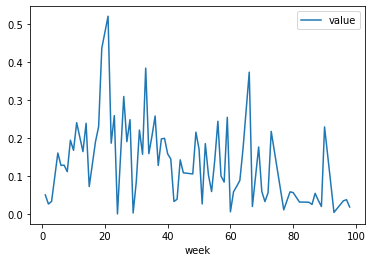

In [155]:
avg[avg.variable == 'Actinobacteriota'].plot(x='week', y='value')